In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
from scipy import stats


In [2]:
!pip install statsmodels
import statsmodels.api as sm
from statsmodels.distributions.mixture_rvs import mixture_rvs

In [3]:
geo_df = pd.read_csv("/content/drive/MyDrive/ProjectGeodata/refinded_geo_dataset.csv", index_col="Unnamed: 0")

**Переведем широты и долготы в (x,y) так как расстояния маленькие, это можно сделать линейно, погрешность меньше промилля**

In [4]:
#ancoring
top_y = 55.12
left_x = 72.99

bottom_y = 54.80
right_x = 73.67

y_side = 35600
x_side = 43400

In [5]:
all_dates_of_geoset = geo_df["FORECAST_DATE"].unique()
points_array = np.array(((geo_df["x_cord"]),(geo_df["y_cord"]) ))
points_array = points_array.T

In [6]:
x_cords_by_dates = geo_df.groupby("FORECAST_DATE")["x_cord"].apply(list).to_dict()
y_cords_by_dates = geo_df.groupby("FORECAST_DATE")["y_cord"].apply(list).to_dict()

**Сгруппируем все заказы по дням и построим по дням гистограммы распределения заказов**

In [7]:
scatter_over_days_tensor = []
for date_key_item in x_cords_by_dates:
  tmp_x_coords_on_day = x_cords_by_dates[date_key_item]
  tmp_y_coords_on_day = y_cords_by_dates[date_key_item]
  scatter_set = np.array((tmp_x_coords_on_day, tmp_y_coords_on_day))
  scatter_over_days_tensor.append(scatter_set)
scatter_over_dates_dict = res = {list(x_cords_by_dates.keys())[i]: scatter_over_days_tensor[i] for i in range(len(scatter_over_days_tensor))}

In [8]:
def histograms_over_day_generator(scatter_over_days_data):
  heatmap_tensor = []
  tmp_histogram = np.histogram2d(scatter_over_days_data[0][0],scatter_over_days_data[0][1], bins = (50,50))
  tmp_histogram_vals = tmp_histogram[0]
  tmp_histogram_bins = tmp_histogram[1]
  heatmap_tensor.append(tmp_histogram_vals)
  for i in range(len(scatter_over_days_data)):
    tmp_histogram = np.histogram2d(scatter_over_days_data[i][0], scatter_over_days_data[i][1], bins = tmp_histogram_bins)
    tmp_histogram_vals = tmp_histogram[0]
    tmp_histogram_bins = tmp_histogram[1]
    heatmap_tensor.append(tmp_histogram_vals)
  heatmap_tensor = np.array(heatmap_tensor[1::])
  return heatmap_tensor

In [9]:
my_heatmap_tensor = histograms_over_day_generator(scatter_over_days_tensor)

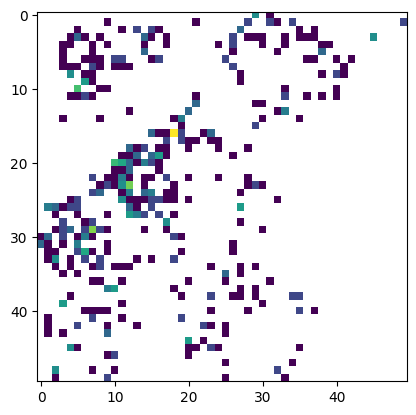

In [51]:
plt.imshow(my_heatmap_tensor[557,:,:], norm = LogNorm())

<Axes: >

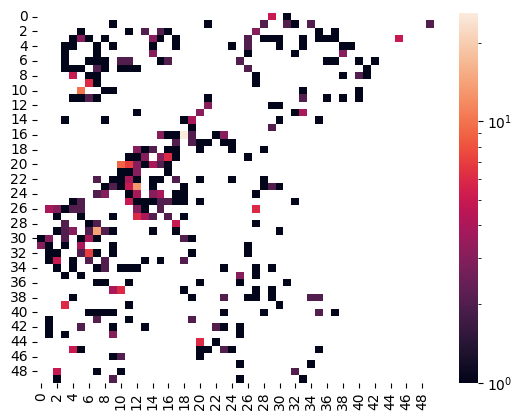

In [52]:
sns.heatmap(my_heatmap_tensor[557,:,:], norm = LogNorm())

**Сделаем из scatter по дням выборку, размера соответствующего предсказаниям временного ряда**

In [24]:
def generate_sample_given_scatter_tensor_slice(scatter_dict, dates_list, sample_size):
  total_scatter = np.array(((0,0),(0,0))).T

  for date in dates_list:
    total_scatter = np.hstack((total_scatter, scatter_dict[date]))
  random_sample_bstrap = np.random.randint(low = 2, high = total_scatter.shape[1]-1, size = sample_size)
  return total_scatter[:,random_sample_bstrap]



In [42]:
some_dates_list = list(x_cords_by_dates.keys())
some_sample = generate_sample_given_scatter_tensor_slice(scatter_over_dates_dict, dates_list=some_dates_list[510:556], sample_size=941)

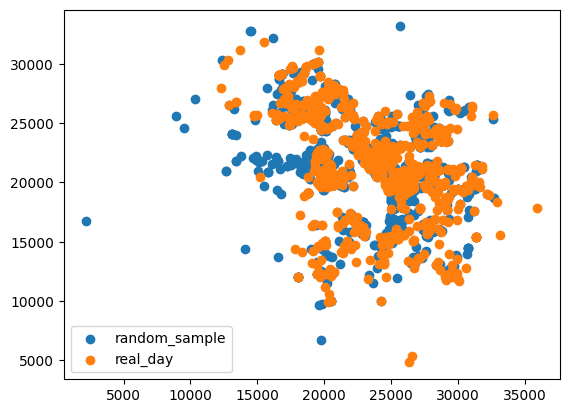

In [43]:
plt.scatter(x = some_sample[0,:], y = some_sample[1,:], label = 'random_sample')
plt.scatter(scatter_over_days_tensor[557][0],scatter_over_days_tensor[557][1], label = 'real_day')
plt.legend()

**Довольно легко видеть что распределения отличаются, для задачи коммивояжера это критично, но, быть может, можно предсказать число курьеров на день**

**Посмотрим какие энтропии у этих распределений**

In [44]:
def entropy_estimator(distribution_heatmap):
  prob_matrix = distribution_heatmap/distribution_heatmap.sum()
  entropy_matrix = np.zeros_like(prob_matrix)
  entropy_matrix[prob_matrix != 0] = prob_matrix[prob_matrix != 0]*np.log(prob_matrix[prob_matrix != 0])
  entropy = -entropy_matrix.sum()
  return entropy

In [53]:
entropy_estimator(my_heatmap_tensor[557,:,:])

5.4925408923387655

In [55]:
sample_hist = np.histogram2d(some_sample[0],some_sample[1], bins = (50,50))
sample_hist_vals = sample_hist[0]

In [57]:
entropy_estimator(sample_hist_vals)

5.3985405189532365

**Хорошо видно что энтропии близки друг к другу, значит можно использовать ее как предиктор числа курьеров не пытаяс построить плотность распределения**
